In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
# preprocessing
import re
import string
import nltk
from nltk import  pos_tag
from nltk.corpus import stopwords
import nltk.stem as stemmer

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec


from collections import Counter
# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report



In [4]:
#read data
dataset= pd.read_csv('gossipcop.csv')
dataset

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,0
...,...,...,...,...,...
22135,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1
22136,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1
22137,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1
22138,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1


In [5]:
print((dataset.label == 1).sum()) # real news number
print((dataset.label == 0).sum()) # fake news number

16817
5323


In [7]:
#rename the title column to news
dataset.rename(columns= {'title': 'news'}, inplace= True)

In [13]:
df= dataset[['news']]
label= dataset[['label']]
other_features= dataset.drop(['news', 'label'], axis= 1)
df.head(3)

,news
0,Did Miley Cyrus and Liam Hemsworth secretly ge...
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...
2,Celebrities Join Tax March in Protest of Donal...


In [ ]:
# cleanning dataset

In [9]:
def remove_URL(text):
  url= re.compile(r'https?://\S+|www\.|S+')
  return url.sub(r"", text)

In [10]:
def remove_punctuation(text):
  trnsltr= str.maketrans("","", string.punctuation)
  return text.translate(trnsltr)

In [14]:
df['news']= df.news.map(remove_punctuation)
df['news']= df.news.map(remove_URL)

<ipython-input-14-a35a6abdf14c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df.news.map(remove_punctuation)
<ipython-input-14-a35a6abdf14c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df.news.map(remove_URL)


In [ ]:
#remove stop words

In [16]:
nltk.download('stopwords')
stop= set(stopwords.words("english"))
def remove_stopwords(text):
  result= [word.lower() for word in text.split() if word.lower() not in stop]
  return ' '.join(result)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df['news']= df.news.map(remove_stopwords)

<ipython-input-17-b1b16693267d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df.news.map(remove_stopwords)


In [18]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [19]:
from nltk.stem import *
from nltk.stem.porter import *
stemmer = PorterStemmer()

pos= pos_tag(df['news'])
df['news'] = [stemmer.stem(tagged_word[0]) for tagged_word in pos]



<ipython-input-19-75a18c877c3d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'] = [stemmer.stem(tagged_word[0]) for tagged_word in pos]


In [20]:
df

,news
0,miley cyrus liam hemsworth secretly get marri
1,paris jackson cara delevingne enjoy night matc...
2,celebrities join tax march protest donald trump
3,cindy crawfords daughter kaia gerber wears wig...
4,full list 2018 oscar nominations – varieti
...,...
22135,2017 hollywood film awards complete list winn
22136,jada pinkett mith explains son jaden moved 15
22137,tinsley mortimer reacts luann de lesseps relaps
22138,prince harry carries princess diana’s legacy a...


In [21]:
# counting unique words of news column
def count_words(text_col):
  counter= Counter()
  for text in text_col:
    for word in text.split():
      counter[word] += 1
  return counter


In [22]:
counter= count_words(df['news'])

In [23]:
# number of unique words
len(counter)

22801

In [24]:
unique_words_num= len(counter)

In [25]:
embedding_dim= 100

In [26]:
# Word2Vec

In [27]:
X= [x.split() for x in df['news'].tolist()]

In [28]:
print(X[0])

['miley', 'cyrus', 'liam', 'hemsworth', 'secretly', 'get', 'marri']


In [29]:
w2v_mdl= Word2Vec(sentences= X, window= 10, min_count=1 )

In [30]:
len(w2v_mdl.wv.index_to_key)

22801

In [31]:
# most similarity of 5 most common words

In [32]:
print(most_common:= counter.most_common(5))

[('new', 1137), ('kardashian', 1065), ('jennifer', 794), ('2018', 754), ('kim', 705)]


In [33]:
print('word is: ',wrd:= most_common[0][0])
w2v_mdl.wv.most_similar(wrd)

word is:  new


[('instagram', 0.9969065189361572),
 ('fear', 0.9966990351676941),
 ('fans', 0.9966177940368652),
 ('impson', 0.9964540004730225),
 ('campaign', 0.996318519115448),
 ('hares', 0.996316134929657),
 ('costume', 0.9962589740753174),
 ('track', 0.9962204694747925),
 ('shares', 0.9962005615234375),
 ('happy', 0.9961593747138977)]

In [34]:
print('word is: ',wrd:= most_common[1][0])
w2v_mdl.wv.most_similar(wrd)

word is:  kardashian


[('kardashian’s', 0.992742657661438),
 ('kuwtk', 0.9896014928817749),
 ('thompson', 0.9883383512496948),
 ('west', 0.9882493615150452),
 ('tristan', 0.9867110252380371),
 ('wests', 0.9860159754753113),
 ('cattrall', 0.9844964742660522),
 ('kardashians', 0.9843482971191406),
 ('north', 0.9834754467010498),
 ('kanye', 0.9824379086494446)]

In [35]:
print('word is: ',wrd:= most_common[2][0])
w2v_mdl.wv.most_similar(wrd)

word is:  jennifer


[('alex', 0.9840958118438721),
 ('rodriguez', 0.9832463264465332),
 ('courteney', 0.9831142425537109),
 ('garner', 0.9810687303543091),
 ('casually', 0.9793148040771484),
 ('affleck', 0.9779932498931885),
 ('anistons', 0.9779021739959717),
 ('aniston’s', 0.9763872623443604),
 ('aniston', 0.9761765599250793),
 ('lawrence', 0.9753913879394531)]

In [36]:
print('word is: ',wrd:= most_common[3][0])
w2v_mdl.wv.most_similar(wrd)

word is:  2018


[('winners', 0.9969887137413025),
 ('ag', 0.9969119429588318),
 ('nominations', 0.9944235682487488),
 ('list', 0.9944152235984802),
 ('winn', 0.9936884641647339),
 ('award', 0.993586003780365),
 ('choice', 0.9928593039512634),
 ('awards', 0.9921836853027344),
 ('cma', 0.9918481111526489),
 ('nominees', 0.9913429021835327)]

In [37]:
print('word is: ',wrd:= most_common[4][0])
w2v_mdl.wv.most_similar(wrd)

word is:  kim


[('tristan', 0.9925581216812134),
 ('khloe', 0.9924763441085815),
 ('north', 0.9918752908706665),
 ('wests', 0.9913380146026611),
 ('thompson', 0.9906131029129028),
 ('khloé', 0.9902854561805725),
 ('kourtney', 0.9892439246177673),
 ('west', 0.9892203211784363),
 ('kuwtk', 0.9887500405311584),
 ('kanye', 0.9881780743598938)]

In [38]:
# vectorize a text into a sequence of integers by tokenizing
# converting text into a sequence of integers
def tokenize(text):
  tokenizer= Tokenizer(num_words= unique_words_num)
  tokenizer.fit_on_texts(text)
  return tokenizer

In [39]:
tokenizer= tokenize(X)


In [40]:
print(word_index:= tokenizer.word_index)

{'new': 1, 'kardashian': 2, 'jennifer': 3, '2018': 4, 'kim': 5, 'jenner': 6, 'baby': 7, 'justin': 8, 'meghan': 9, 'prince': 10, 'first': 11, 'eason': 12, 'wedding': 13, 'brad': 14, '–': 15, 'reveals': 16, 'elena': 17, '—': 18, 'tar': 19, 'watch': 20, 'best': 21, 'taylor': 22, '2017': 23, 'video': 24, 'pitt': 25, 'awards': 26, 'kylie': 27, 'harry': 28, 'ee': 29, 'ays': 30, 'kate': 31, 'gomez': 32, 'back': 33, 'photo': 34, 'angelina': 35, 'markle': 36, 'report': 37, 'get': 38, '2': 39, 'cott': 40, 'tv': 41, 'royal': 42, 'blake': 43, 'chris': 44, 'relationship': 45, 'award': 46, 'birthday': 47, 'love': 48, 'day': 49, 'aniston': 50, 'family': 51, 'west': 52, 'wift': 53, 'kanye': 54, 'look': 55, 'ex': 56, 'khloe': 57, 'jolie': 58, 'plit': 59, 'tars': 60, 'daughter': 61, 'dating': 62, 'bella': 63, 'pregnant': 64, 'music': 65, 'bieber': 66, 'red': 67, 'real': 68, 'james': 69, 'trump': 70, 'mom': 71, 'year': 72, 'tom': 73, 'ryan': 74, 'know': 75, 'worth': 76, 'inside': 77, 'gets': 78, 'divorce

In [41]:
tokenizer.word_counts

OrderedDict([('miley', 150),
             ('cyrus', 151),
             ('liam', 131),
             ('hemsworth', 81),
             ('secretly', 9),
             ('get', 334),
             ('marri', 49),
             ('paris', 149),
             ('jackson', 173),
             ('cara', 22),
             ('delevingne', 13),
             ('enjoy', 43),
             ('night', 184),
             ('matching', 29),
             ('outfits', 27),
             ('‘amazing', 4),
             ('chemistry’', 1),
             ('celebrities', 153),
             ('join', 40),
             ('tax', 5),
             ('march', 31),
             ('protest', 13),
             ('donald', 106),
             ('trump', 238),
             ('cindy', 23),
             ('crawfords', 4),
             ('daughter', 252),
             ('kaia', 30),
             ('gerber', 25),
             ('wears', 92),
             ('wig', 9),
             ('dining', 2),
             ('harry', 384),
             ('tyl', 36),
          

In [42]:
text_sentences= df['news'].to_numpy()
text_sequences= tokenizer.texts_to_sequences(X)


In [43]:
print(text_sentences[100])
print(text_sequences[100])

throwback alert relive pippa middletons cenetealing appearance kate middletons wed
[1334, 1936, 1758, 417, 741, 11919, 825, 31, 741, 109]


In [44]:
#reversing tokenization
# test_sequences

In [45]:
# min and max lengh of train sequences
train_min_lenght= len(min(text_sequences, key= len))
train_max_lenght= len(max(text_sequences, key= len))
train_min_lenght , train_max_lenght


(0, 26)

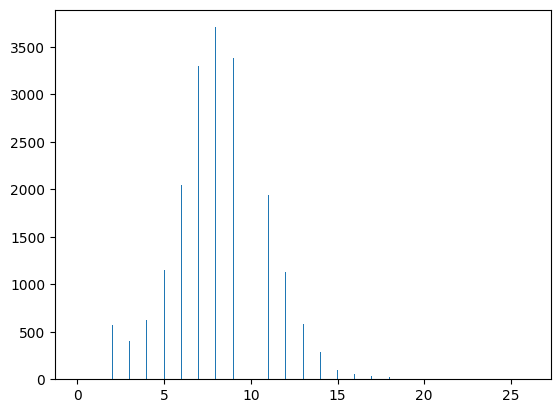

In [46]:
# plotting len of each sentence
plt.hist([len(x) for x in X], bins=500);

In [48]:
sentence_len= np.array([len(x) for x in X])
print(f'There are {len(sentence_len[sentence_len > 15])} sentences which have more than 25 words.')
max_len= 15

There are 126 sentences which have more than 25 words.


In [49]:
# padding
def padding_sequences(seq, max_len):
  return pad_sequences(seq, maxlen= max_len, padding= "post", truncating="post")

In [50]:
text_padded= padding_sequences(text_sequences, max_len)

In [52]:
print(text_sentences[100])
print(text_sequences[100])
print(text_padded[100])

throwback alert relive pippa middletons cenetealing appearance kate middletons wed
[1334, 1936, 1758, 417, 741, 11919, 825, 31, 741, 109]
[ 1334  1936  1758   417   741 11919   825    31   741   109     0     0
     0     0     0]


In [53]:
# checking tokenization by reversing from sequences to sentences
# filp word_index dictionay index and value
reversed_index= dict([(idx, word) for (word, idx) in word_index.items()])

In [54]:
def decode(seq):
  result= " ".join([reversed_index.get(idx, "?") for idx in seq])
  return result

In [55]:
decoded_news= decode(text_sequences[100])
print(text_sequences[100])
print(text_sentences[100])
print(decoded_news)

[1334, 1936, 1758, 417, 741, 11919, 825, 31, 741, 109]
throwback alert relive pippa middletons cenetealing appearance kate middletons wed
throwback alert relive pippa middletons cenetealing appearance kate middletons wed


In [56]:
#concatinating other features to tokenized data

In [57]:
##### concatnate if other features exist
# train_padded= np.hstack([train_padded, train_other_features])
# test_padded= np.hstack([test_padded, test_other_features])


In [58]:
# unique_words_num
# other_feauter_lengh= test_other_features.shape[1]
# other_feauter_lengh

In [59]:
# vocab_size
vocab_size= len(tokenizer.word_index) +1 # because word_index starts from zero

In [60]:
def get_weight_matrix(model):
  weight_matrix= np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
    weight_matrix[i]= model.wv[word]
  return weight_matrix


In [61]:
embedding_vectors= get_weight_matrix(w2v_mdl)

In [62]:
X_train, X_test, y_train, y_test= train_test_split(text_padded, label, test_size= 0.2, random_state= 10)

In [63]:

# create LSTM model
model= keras.models.Sequential()
model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  input_length= max_len , trainable=False)) # with other features
model.add(layers.LSTM(128, dropout= 0.1))
model.add(layers.Dense(1,  activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           2280200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,397,577
Trainable params: 117,377
Non-trainable params: 2,280,200
_________________________________________________________________


In [64]:
loss= keras.losses.BinaryCrossentropy(from_logits= False)
optim= keras.optimizers.Adam(learning_rate=0.005)
metrics= ["accuracy"]#,  Precision(), Recall()]
model.compile(loss= loss, optimizer= optim, metrics= metrics)

In [65]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)


Epoch 1/50
554/554 - 13s - loss: 0.5508 - accuracy: 0.7604 - val_loss: 0.5556 - val_accuracy: 0.7550 - 13s/epoch - 23ms/step
Epoch 2/50
554/554 - 3s - loss: 0.5518 - accuracy: 0.7607 - val_loss: 0.5567 - val_accuracy: 0.7550 - 3s/epoch - 6ms/step
Epoch 3/50
554/554 - 3s - loss: 0.5507 - accuracy: 0.7607 - val_loss: 0.5588 - val_accuracy: 0.7550 - 3s/epoch - 5ms/step
Epoch 4/50
554/554 - 3s - loss: 0.5511 - accuracy: 0.7607 - val_loss: 0.5586 - val_accuracy: 0.7550 - 3s/epoch - 5ms/step
Epoch 5/50
554/554 - 4s - loss: 0.5506 - accuracy: 0.7607 - val_loss: 0.5609 - val_accuracy: 0.7550 - 4s/epoch - 7ms/step
Epoch 6/50
554/554 - 3s - loss: 0.5523 - accuracy: 0.7607 - val_loss: 0.5571 - val_accuracy: 0.7550 - 3s/epoch - 5ms/step
Epoch 7/50
554/554 - 3s - loss: 0.5355 - accuracy: 0.7658 - val_loss: 0.5113 - val_accuracy: 0.7818 - 3s/epoch - 5ms/step
Epoch 8/50
554/554 - 3s - loss: 0.5064 - accuracy: 0.7826 - val_loss: 0.4927 - val_accuracy: 0.7855 - 3s/epoch - 5ms/step
Epoch 9/50
554/554 - 

In [66]:
y_pred= (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

139/139 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.64      0.50      0.56      1085
           1       0.85      0.91      0.88      3343

    accuracy                           0.81      4428
   macro avg       0.74      0.70      0.72      4428
weighted avg       0.80      0.81      0.80      4428



In [67]:
# Bidirectional LSTM

In [68]:
bi_model =  keras.models.Sequential()
bi_model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  input_length= max_len , trainable=False))
bi_model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.1)))  # Use Bidirectional LSTM layer
bi_model.add(layers.Dense(1, activation='sigmoid'))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"] #, Precision(), Recall()]

bi_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [69]:
bi_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)


Epoch 1/50
554/554 - 8s - loss: 0.5639 - accuracy: 0.7589 - val_loss: 0.5538 - val_accuracy: 0.7550 - 8s/epoch - 14ms/step
Epoch 2/50
554/554 - 4s - loss: 0.5379 - accuracy: 0.7620 - val_loss: 0.5305 - val_accuracy: 0.7633 - 4s/epoch - 7ms/step
Epoch 3/50
554/554 - 3s - loss: 0.5200 - accuracy: 0.7718 - val_loss: 0.5228 - val_accuracy: 0.7674 - 3s/epoch - 6ms/step
Epoch 4/50
554/554 - 3s - loss: 0.5148 - accuracy: 0.7717 - val_loss: 0.5193 - val_accuracy: 0.7660 - 3s/epoch - 6ms/step
Epoch 5/50
554/554 - 3s - loss: 0.5123 - accuracy: 0.7733 - val_loss: 0.5170 - val_accuracy: 0.7683 - 3s/epoch - 6ms/step
Epoch 6/50
554/554 - 4s - loss: 0.5106 - accuracy: 0.7734 - val_loss: 0.5157 - val_accuracy: 0.7685 - 4s/epoch - 7ms/step
Epoch 7/50
554/554 - 3s - loss: 0.5085 - accuracy: 0.7754 - val_loss: 0.5143 - val_accuracy: 0.7690 - 3s/epoch - 6ms/step
Epoch 8/50
554/554 - 3s - loss: 0.5077 - accuracy: 0.7746 - val_loss: 0.5129 - val_accuracy: 0.7703 - 3s/epoch - 6ms/step
Epoch 9/50
554/554 - 4s

In [70]:
y_pred= (bi_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

139/139 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.70      0.31      0.43      1085
           1       0.81      0.96      0.88      3343

    accuracy                           0.80      4428
   macro avg       0.75      0.63      0.66      4428
weighted avg       0.78      0.80      0.77      4428



In [71]:
S_model =  keras.models.Sequential()
S_model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  input_length= max_len , trainable=False))
S_model.add(layers.SimpleRNN(128, dropout=0.1))
S_model.add(layers.Dense(1, activation='sigmoid'))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"] #, Precision(), Recall()]

S_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [72]:
S_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)


Epoch 1/50
554/554 - 11s - loss: 0.5339 - accuracy: 0.7676 - val_loss: 0.5133 - val_accuracy: 0.7778 - 11s/epoch - 20ms/step
Epoch 2/50
554/554 - 9s - loss: 0.5005 - accuracy: 0.7824 - val_loss: 0.5005 - val_accuracy: 0.7803 - 9s/epoch - 17ms/step
Epoch 3/50
554/554 - 10s - loss: 0.4940 - accuracy: 0.7837 - val_loss: 0.4952 - val_accuracy: 0.7850 - 10s/epoch - 18ms/step
Epoch 4/50
554/554 - 10s - loss: 0.4880 - accuracy: 0.7865 - val_loss: 0.4917 - val_accuracy: 0.7852 - 10s/epoch - 18ms/step
Epoch 5/50
554/554 - 9s - loss: 0.4838 - accuracy: 0.7876 - val_loss: 0.4913 - val_accuracy: 0.7848 - 9s/epoch - 17ms/step
Epoch 6/50
554/554 - 8s - loss: 0.4819 - accuracy: 0.7912 - val_loss: 0.4891 - val_accuracy: 0.7836 - 8s/epoch - 15ms/step
Epoch 7/50
554/554 - 10s - loss: 0.4777 - accuracy: 0.7938 - val_loss: 0.4890 - val_accuracy: 0.7846 - 10s/epoch - 17ms/step
Epoch 8/50
554/554 - 10s - loss: 0.4767 - accuracy: 0.7925 - val_loss: 0.4857 - val_accuracy: 0.7888 - 10s/epoch - 18ms/step
Epoch 

In [73]:
y_pred= (S_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

139/139 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.61      0.30      0.40      1085
           1       0.81      0.94      0.87      3343

    accuracy                           0.78      4428
   macro avg       0.71      0.62      0.64      4428
weighted avg       0.76      0.78      0.75      4428

